#  앙상블 학습

* 앙상블 학습의 유형은 보팅, 배깅, 부스팅 세가지로 나눌 수 있으며 이외에도 스태깅을 포함한 다양한 앙상블 방법이 있다.
* 보팅의 경우 서로 다른 알고리즘을 가진 분류기를 결합하는 것이고 배깅의 경우 각각의 분류기 모두 같은 유형의 알고리즘 기반이다.
* 정형 데이터의 예측 분석 영역에서는 매우 높은 예측 성능
* 배깅 방식의 대표인 Random Forest는 뛰어난 예측 성능, 상대적으로 빠른 수행시간, 유연성 등으로 애용.
* 부스팅의 효시는 Gradient Boosting, 한 단계 발전시키면서도 시간 단축시킨 XgBoost, LightGBM이 정형 데이터의 분류 영역에서 
  활용도 확대
* 앙상블의 앙상블이라고 불리는 스태킹 기법
* 앙상블의 기본 알고리즘은 결정 트리

## 1. Voting Classifier
- 하드 보팅 : 다수결 원칙, 다수의 분류기가 결정한 예측값을 최종 보팅 결과값으로 선정
- 소프트 보팅 : 분류기들의 레이블 값 결정 확률을 모두 더해서 평균하고 이들 중 가장 높은 레이블 값을 최종 보팅 결과값으로 선정


In [3]:
import pandas as pd
from sklearn.ensemble import VotingClassifier # 보팅 분류기 생성
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.datasets import load_breast_cancer # 사이킷런 데이터셋 자료
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [8]:
cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [ ]:
data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)

In [17]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 소프팅 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft') # 입력값: estimators와 voting 값(소프트인지 하드인지) 출력: 보팅 분류기 생성

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state = 156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
y_pred = vo_clf.predict(X_test)

print('Voting분류기 정확도: ', accuracy_score(y_test, y_pred))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print(f'{class_name} 정확도: {accuracy_score(y_test, pred) :.4f}')

Voting분류기 정확도:  0.9473684210526315
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


=> voting분류기가 개별 모델의 정확도보다 좋아짐 (무조건 예측성능이 향상되지 않음)

## 2. RandomForest (배깅의 대표적인 알고리즘)
https://eunsukimme.github.io/ml/2019/11/26/Random-Forest/

In [10]:
# 사용자 함수 생성
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df


In [8]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
# 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [11]:
# 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
feature_name_df = pd.read_csv('human_activity/features.txt',sep='\s+',
                    header=None,names=['column_index','column_name'])
new_features_name_df = get_new_feature_name_df(feature_name_df)
print(new_features_name_df.shape)
new_features_name_df.head()

(561, 3)


,column_index,column_name,dup_cnt
0,1,tBodyAcc-mean()-X,0
1,2,tBodyAcc-mean()-Y,0
2,3,tBodyAcc-mean()-Z,0
3,4,tBodyAcc-std()-X,0
4,5,tBodyAcc-std()-Y,0


In [13]:
fdd = new_features_name_df.groupby('column_name').count()
fdd[fdd.column_index>1].count()

column_index    0
dup_cnt         0
dtype: int64

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'랜덤포레스트 정확도: {round(accuracy, 4)}')

랜덤포레스트 정확도: 0.9253


=> 최적의 하이퍼파라미터 구해보기

In [18]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100], #랜덤포레스트는 Dt와 다르게 트리가 여러개라 여러개의 estimator 값을 지정해야함(여기선 100개의 그룹)
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [8, 12, 18],
    'min_samples_split': [8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1) #n_jobs=-1은 돌아가는 내역을 보여줌
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)
print('최적의 파라미터:', grid_cv.best_params_)
print('최고 예측 정확도:', grid_cv.best_score_)

최적의 파라미터: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9179815016322089


In [20]:
# 1. 최적의 estimator 적용하여  다시 학습(best_estimator_사용)

best_estimator = grid_cv.best_estimator_
best_estimator.fit(X_train, y_train)
best_pred = best_estimator.predict(X_test)

print('정확도:', accuracy_score(y_test, best_pred))

정확도: 0.9195792331184255


### RandomForest 중요도 시각화

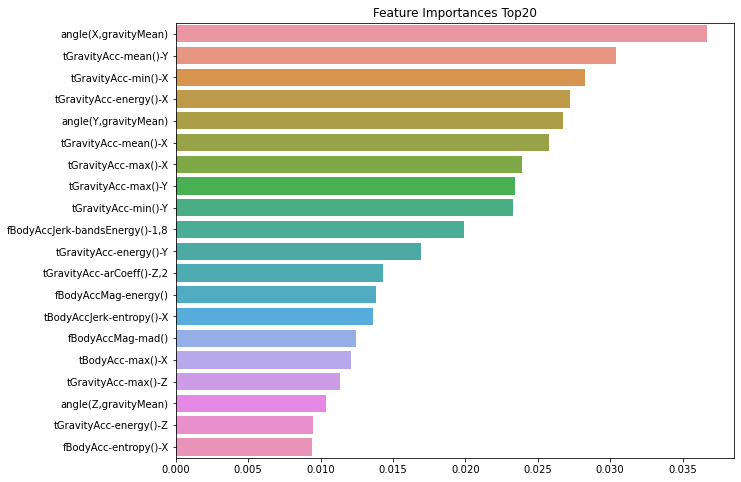

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# feature_importances_사용하여 피처의 중요도 확인하기

ftr_importances_values = best_estimator.feature_importances_ # 위에서 적용한 best_estimator 적용한 것 불러오기
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
plt.title('Feature Importances Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

#### 과제_0921_1 
수작업으로 하이퍼파라미터를 3가지 유형으로 변환하여 모델 학습 후 평가 결과를 비교하세요.

In [ ]:
# 2. 다양한 estimator 적용하여  다시 학습 (수작업을 수행 했을 때)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# fot문 이용하여 각각 적용한 데이터 추출
# best_params={'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}

n_esti = [300, 200, 150, 100]
max_dep = [9, 8, 10, 10]
min_split = [8, 16, 20, 8]
min_leaf = [8, 12, 18, 8]

for n_es, depth, split, leaf in zip(n_esti, max_dep, min_split, min_leaf):
    rf_clf = RandomForestClassifier(n_estimators = n_es, max_depth = depth, min_samples_split= split, min_samples_leaf=leaf, random_state=0)
    rf_clf.fit(X_train, y_train)
    
    pred = rf_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('parameters')
    print(f'n_estimators: {n_es}, max_depth: {depth}, min_samples_split: {split}, min_samples_leaf: {leaf}')
    print(f'정확도 = {accuracy: .3f}')

parameters
n_estimators: 300, max_depth: 9, min_samples_split: 8, min_samples_leaf: 8
정확도 =  0.918
parameters
n_estimators: 200, max_depth: 8, min_samples_split: 16, min_samples_leaf: 12
정확도 =  0.913
parameters
n_estimators: 150, max_depth: 10, min_samples_split: 20, min_samples_leaf: 18
정확도 =  0.915
parameters
n_estimators: 100, max_depth: 10, min_samples_split: 8, min_samples_leaf: 8
정확도 =  0.920


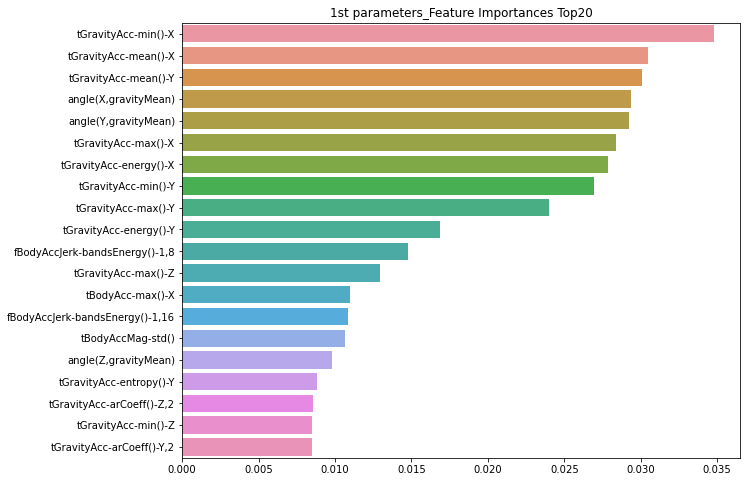

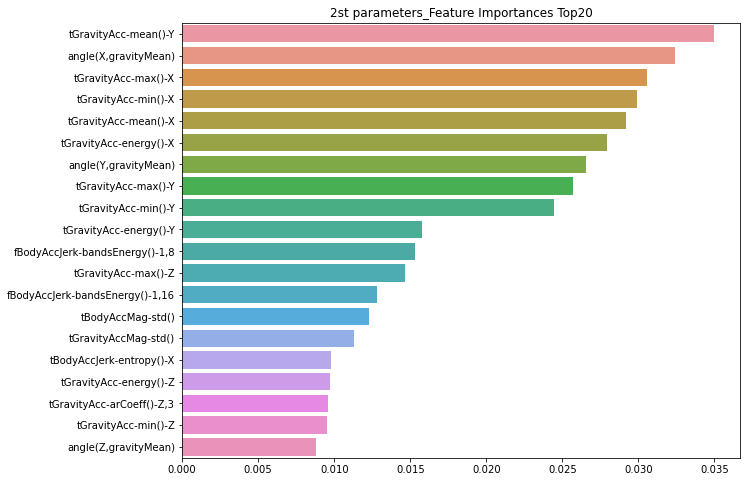

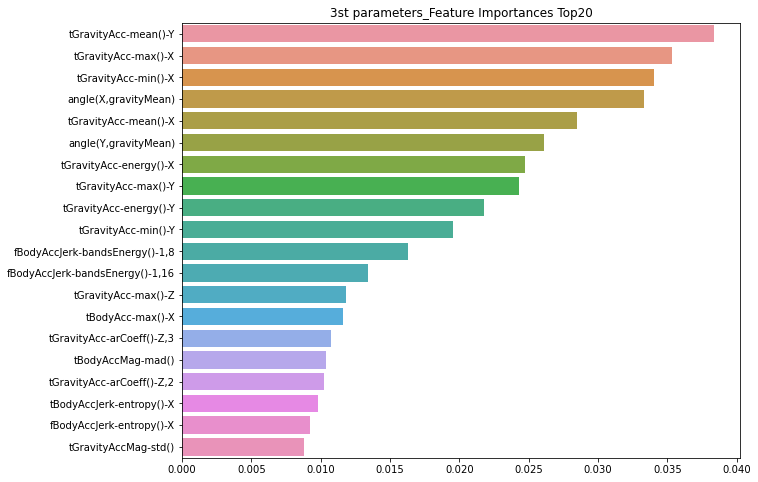

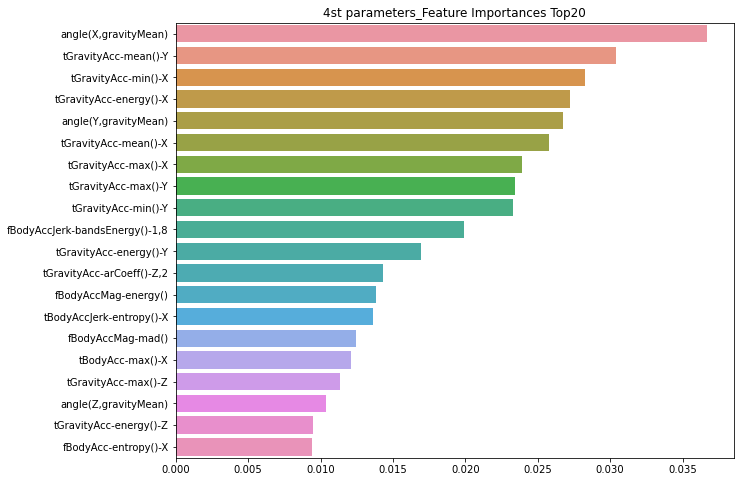

In [51]:
# 위 값들의 피처 중요도를 시각화하기 (feature_importances_사용)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ax = [1,2,3,4]
for ax, n_es, depth, split, leaf in zip(ax, n_esti, max_dep, min_split, min_leaf):
    rf_clf = RandomForestClassifier(n_estimators = n_es, max_depth = depth, min_samples_split= split, min_samples_leaf=leaf, random_state=0)
    rf_clf.fit(X_train, y_train)
    
    ftr_importances_values = rf_clf.feature_importances_ # 위에서 적용한 파라미터로 학습한 예측모델 불러오기
    ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

    plt.figure(figsize=(10, 8))
    plt.title(f'{ax}st parameters_Feature Importances Top20')
    sns.barplot(x=ftr_top20, y=ftr_top20.index)
    plt.show()

=> 피처의 중요도 값이 살짝씩 다르지만 전체적인 그래프 모양은 거의 동일

## 3. GBM(Gradient Boosting Machine)
- 부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 가중치 업데이트를 경사 하강법(Gradient Descent)를 이용한다.
- 분류는 물론이고 회귀도 가능
- 파라미터 : n_estimators, max_depth, max_features
 - loss : 경사하강법에서 사용할 비용함수 지정. 기본값 deviance 적용
 - learning_rate : GBM이 학습할 때마다 적용할 학습률.오류값 보정 시 적용하는 계수로 0 ~ 1 사이의 값 지정. 기본값은 0.1. 작게 설정하면 예측성능이 높아지나 수행시간이 오래 걸리고 큰 값을 적용하면 예측 성능이 떨어질 가능성이 높으나 빠른 수행이 가능. n_estimator와 상호 보완적으로 조합해 사용
 - n_estimator : weak learner의 개수
 - subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율. 기본값은 1


In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time() # GBM 수행 시간 측정

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f'GBM 정확도: {gb_accuracy: .3f}')
print(f'GBM 수행 시간: {time.time()-start_time}초')

GBM 정확도:  0.939
GBM 수행 시간: 538.2174875736237초


#### 과제_0921_2
위 문제에 대하여 성능 개선을 수행하세요.

최적의 파라미터: {'learning_rate': 0.1, 'n_estimators': 500}
최고 예측 정확도: GradientBoostingClassifier(n_estimators=500, random_state=0)
걸린시간: 6783.070483446121

 <bestestimator로 다시 실행>
정확도: 0.9195792331184255
정확도추출까지 걸린시간: 6783.1626143455505
그래프 출력


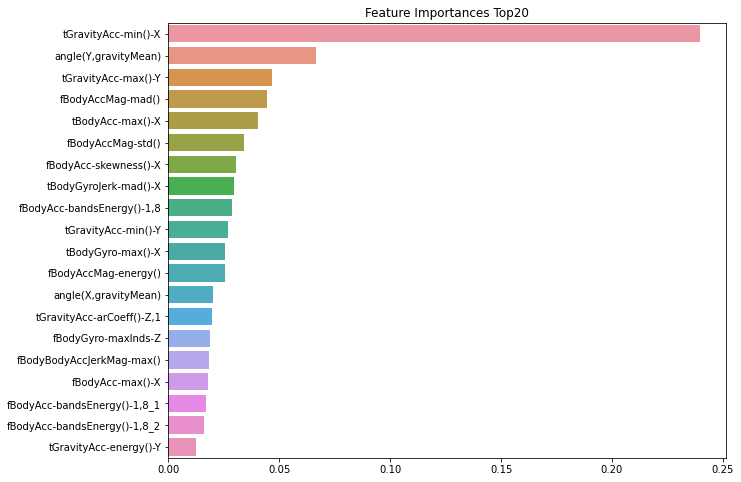

총 걸린시간: 6783.428666353226


In [53]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 500],
    'learning_rate': [0.05, 0.1] # GBM이 학습이 진행할 때마다 적용하는 학습률(0~1, 기본값:0.1)
}
X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time() # GBM 수행 시간 측정

gb_clf = GradientBoostingClassifier(random_state=0)
grid_cv_gb = GridSearchCV(gb_clf, param_grid = params, cv=5, n_jobs=-1)
grid_cv_gb.fit(X_train, y_train)
print('최적의 파라미터:', grid_cv_gb.best_params_)
print('최고 예측 정확도:', grid_cv_gb.best_estimator_)
print(f'걸린시간: {time.time()-start_time}')

print('\n', '<bestestimator로 다시 실행>')
# best_estimator로 다시 실행
best_esti = grid_cv_gb.best_estimator_
best_pred = best_estimator.predict(X_test)
print('정확도:', accuracy_score(y_test, best_pred))
print(f'정확도추출까지 걸린시간: {time.time()-start_time}')

print('===========================================================================================')
print('그래프 출력')
# 그래프 출력
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# feature_importances_사용하여 피처의 중요도 확인하기

ftr_importances_values = best_esti.feature_importances_ # 위에서 적용한 best_estimator 적용한 것 불러오기
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
plt.title('Feature Importances Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()
print(f'총 걸린시간: {time.time()-start_time}')